# DCGAN & WGAN - MNIST & Pokémon Generation

In this notebook, I will experiment with DCGAN and WGAN models for the generation of MNIST digits as well as trying to generate images of Pokémon. 

## DCGAN

DCGAN (Deep Convolutional Generative Adversarial Network) is a type of GAN, which is a generative model trained using adversarial examples. Two networks, a discriminator and a generator, are competing with each other. The generator's job is to generate fake images in order to fool the discriminator and the discriminator is trying to classify between real images and the images generated by the generator. As a result, the idea is the generator will start generating images that look like the real images used in the traiing set. 

More specifically, a DCGAN uses fully convolutional neural networks for both the discriminator and generator network, as opposed to fully-connected neural networks in vanilla GANs. 

The typical setup for a DCGAN uses a sequence of convolutional layers, batch-normalisation layers, and leaky-relu activation functions. The discriminative network takes in an input image and downsamples into a single number, which signifies whether the network believes the image is real (1) or fake (0). The generator network takes in a random latent vector and upsamples using tranposed convolutional layers into a image. An example of these networks can be seen below.

![dcgan](Deep-convolutional-generative-adversarial-networks-DCGAN-for-generative-model-of-BF-NSP.png) (Courtesy of https://www.researchgate.net/figure/Deep-convolutional-generative-adversarial-networks-DCGAN-for-generative-model-of-BF-NSP_fig3_331282441)

In the original GAN framework, the loss function can be written as 

$$
\min_G \max_D \mathbb{E}_{x\sim p_{data}(x)}[\log D(x)] + \mathbb{E}_{z\sim p_{gen}(z)}[\log(1 - D(G(z))]
$$

GANs are typically known for having an instable training procedure, often failing to converge or suffering from mode collapse. Mode collapse is when the images generated from the generator network have low variance and therefore look similar to each other. For example, MNIST consists of ten distinct different digits (0 - 9), meaning there exists ten different modes to this data. Mode collapses occurs when the network gets stuck in one of these modes.

There are a variety of tricks that have been developed to help with training stabilisation and mode collapse. 

- Instead of minimising $\log(1 - D(G(z))$ for the generator, it is better to maximise $\log(D(G(z)))$. This is because the first formulation has vanishing gradients early on in training.


- Generate latents from a Gaussian distribution, rather than a uniform.


- Generate real and fake image batches separately and accumulate the gradients independently. 


- Use batch normalisation.


- Use LeakyReLU to avoid sparse gradients.


- Downsample and upsample using convolutions with stride, rather than max pooling layers.


- Use soft labels. When the target label is real, instead of using '1' use a random value between [0.8, 1.2] and when the target label is fake, instead of using '0', use a random value between [0, 0.3]. 


- Use Adam optimiser with a suggested learning rate of 0.0002 and beta_1 of 0.05.


- Use an entirely different loss function! (Wasserstein Distance, often known as the Earth-Mover Distance). 

## WGAN (Wasserstein GAN)

Minimising the loss function used for the DCGAN above using an optimal discriminator can be shown to be equivalent to minimising the JS-divergence (Jensen-Shannon). 

$$ JS(\mathbb{P}||\mathbb{Q}) = \frac{1}{2} D(\mathbb{P} || \frac{1}{2} (\mathbb{P} + \mathbb{Q})) + \frac{1}{2}D(\mathbb{Q} || \frac{1}{2} (\mathbb{P} + \mathbb{Q})) $$

By observing the gradients of this loss function as we move the distribution Q further away from P, it can be seen that if there is a large difference between the distributions, the gradient becomes negligable. Consequently, if the generator is producing samples that are wildly different from the real samples, then the generator is not going to learn. 

Another huge problem with minimising the JS-divergence is that the loss function is not continuous everywhere and can learn to exploding gradients and training instability. This can be seen using a simple example. 

Consider the example where we have a probability distribution $\mathbb{P}_0$ of $(0, Z) \in \mathbb{R}^2$ and another probability distribution $\mathbb{P}_\theta$ of $(\theta, Z) \in \mathbb{R}^2$ where $Z \sim U(0, 1)$. Then the JS-divergence can be seen to be

$$JS(\mathbb{P}_0||\mathbb{P}_\theta) = \left\{
\begin{array}{ll}
      \log(2) & \theta \neq 0 \\
      0 & \theta = 0 \\
\end{array} 
\right. $$

which is not differentiable everywhere (when $\theta = 0$).

Now, instead, let us consider the Wasserstein Distance between two distributions, 

$$W(\mathbb{P}, \mathbb{Q}) =  \inf_{\gamma\in \Pi(\mathbb{P}, \mathbb{Q})} \mathbb{E}_{(x, y)\sim\gamma} \big[||x - y||\big]$$

The Wasserstein distance (also known as the Earth-Mover distance) tells us the lower-bound of mass required to be transported from $x$ to $y$ in order to transform a distribution $\mathbb{P}$ to the distribution $\mathbb{Q}$. 

If we consider the same problem as above, we can see that the Wasserstein distance between $\mathbb{P}_0$ and $\mathbb{P}_\theta$ is: 

$$W(\mathbb{P}_0, \mathbb{P}_\theta) = |\theta|$$

which is continuous everywhere. Furthermore, in general, as long as:

1. The generator function is continuous in its parameters, the Wasserstein distance between a fixed distribution will be continuous.
2. If the generator function is locally Lipschitz and satifies 1. then the Wasserstein distance between a fixed distribution is continuous everywhere, and differentiable almost everywhere. 

where Lipschitz contuity ensures that the function is limited in how fast it can change, ensuring that the gradients do not explode.

$${\displaystyle |f(x_{1})-f(x_{2})|\leq K|x_{1}-x_{2}|.}$$

Unfortunately, the Wasserstein distance is intractable as the number of combinations required to find the optimal transport plan $\Pi(\mathbb{P}, \mathbb{Q})$ exponentially increases with the number of dimensions considered. 

Fortunately, the problem can be simplified by utilising Kantorovich-Rubinstein duality, which tells us that the Wasserstein distance can be rewritten as: 

$$W(\mathbb{P}, \mathbb{Q}) = \sup_{||f||_L \leq 1} \mathbb{E}_{x\sim\mathbb{P}}[f(x)] - \mathbb{E}_{x\sim\mathbb{Q}}[f(x)]$$

where the supremum is over all the 1-Lipschitz functions $f : \mathcal{X}\rightarrow\mathbb{R}$

Therefore, to calculate the Wasserstein distance, we need to find a 1-Lipschitz function. This can be done by building a neural network to learn it. This is similar to a Discriminator, but without a Sigmoid function for classification. This neural network is known as a Critic.

The new objective function can then be written as: 

$$\sup_{||f||_L \leq 1} \mathbb{E}_{x\sim p_{data}}[f(x)] - \mathbb{E}_{z\sim p_{gen}}[f(G(z))]$$


Generally, it has been found that by using the Wasserstein distance, GANs are more well-behaved leading to more stablised training, as well as alleviating the problem of mode collapse.

Furthermore, unlike with the JS-divergence loss function, the Wasserstein loss function is correlated with the quality of the samples produced. This allows for easier hyper-parameter tuning and quality-control without having to check samples at each stage of training.

### Ensuring the discriminator is 1-Lipschitz 
There are two main approaches to enforce that the learned discriminator is 1-Lipschitz. 

#### Weight Clipping
In the original paper, the authors decide to clip the weights of the discriminator's neural network. Although this can help with 1-Lipschitz continuity, it can also dramatically reduce the capacity of the discriminator. It was also found that the weight clipping hyperparameter is extremely sensitive, small changes can lead to vanishing/exploding gradients, and therefore cause convergence issues.

#### Gradient Penality (WGAN-GP)
Another approach is penalising the loss function with a gradient penality (https://arxiv.org/pdf/1704.00028.pdf). In this paper, they show that by adding a regularisation term corresponding to keeping the gradient of the discrimator to 1, the gradient norms were much better behaved, the discriminator has a greater complexity in capacity, and the quality of the generator increases.

The loss function becomes:

$$\mathbb{E}_{\mathbf{\tilde{x}\sim\mathbb{P}_g}} [D(\tilde{\mathbf{x}})] - \mathbb{E}_{\mathbf{x}\sim\mathbb{P}_r} [D(\mathbf{x})] + \lambda \mathbb{E}_{\mathbf{\hat{x}\sim\mathbb{P}_{\mathbf{\hat{x}}}}} [(||\nabla_\mathbf{\hat{x}} D(\mathbf{\hat{x}})||_{2} - 1)^2] $$

where $\hat{x} = t\tilde{x} + (1 - t)x$, where $t \sim U(0, 1)$. Typically, $\lambda$ is chosen to be 10.

## Imports and Mount Google Drive to access data + src files

In [17]:
from PIL import Image
import torch
import torch.nn as nn
import torchvision
import torchvision.datasets as dset
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

from utility import generate_latent
# from google.colab import drive
# drive.mount('/content/drive')

# Change path to access modules within Google Drive
# import sys
# sys.path.append('/content/drive/My Drive/dcgan/src')

import matplotlib as mpl
%matplotlib inline
mpl.style.use('seaborn')

## Using a DCGAN on the MNIST Dataset

In [20]:
from dcgan import DCGAN

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

input_channels = 1
hidden_channels = 32
output_channels = 1
latent_dimension = 100
image_size = 32

test_latents = generate_latent(latent_dimension, 5).to(device)
criterion = nn.BCELoss()

model = DCGAN(input_channels=input_channels,
              hidden_channels=hidden_channels,
              output_channels=output_channels,
              latent_dimension=latent_dimension,
              image_size=image_size,
              lr=lr, 
              device=device)

model.load_model(load_name='../data/models/mnist_32_dcgan')

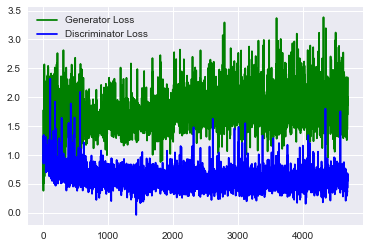

In [46]:
import pickle as pkl

with open('../data/models/mnist_32_dcgan_gen_losses.pkl', 'rb') as f:
    gen_losses = pkl.load(f)

with open('../data/models/mnist_32_dcgan_dis_losses.pkl', 'rb') as f:
    dis_losses = pkl.load(f)
        
gen_losses_spaced = []
dis_losses_spaced = []

for i in range(len(gen_losses)):
    if i % 20 == 0:
        gen_losses_spaced.append(gen_losses[i])
        dis_losses_spaced.append(dis_losses[i])
    
plt.plot(gen_losses_spaced, color='g', label='Generator Loss')
plt.plot(dis_losses_spaced, color='b', label='Discriminator Loss')
plt.legend()

plt.show()

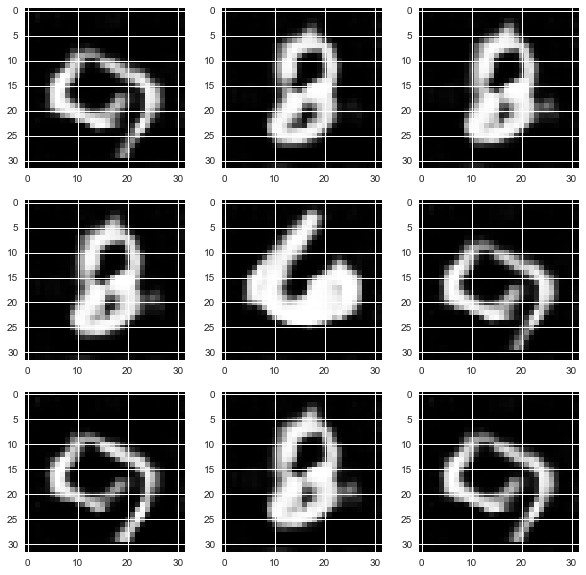

In [22]:
%matplotlib inline

import matplotlib.pyplot as plt

latents = generate_latent(latent_dimension, 9)
generator_output = model.generate(latents).detach().reshape(3, 3, 32, 32)

fig, ax = plt.subplots(3, 3, figsize=(10, 10))

for i in range(3):
    for j in range(3):
        generated_image = model.denormalise_pixels(generator_output[i][j])
        ax[i][j].imshow(generated_image, cmap='gray')

plt.show()


## Using a WGAN on the MNIST Dataset

In [41]:
from wgan import WGAN

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

input_channels = 1
hidden_channels = 32
output_channels = 1
latent_dimension = 100

lr = 0.0001

num_epochs = 40
batch_size = 32
image_size = 32

model = WGAN(input_channels=input_channels,
              hidden_channels=hidden_channels,
              output_channels=output_channels,
              latent_dimension=latent_dimension,
              image_size=image_size,
              lr=lr, 
              device=device)

model.load_model(load_name='../data/models/mnist_32_wgan')

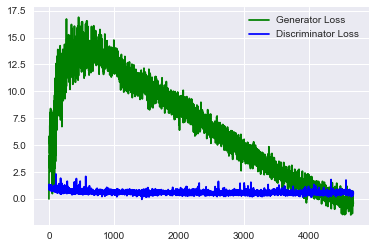

In [62]:
import pickle as pkl

with open('../data/models/mnist_32_wgan_gen_losses.pkl', 'rb') as f:
    gen_losses = pkl.load(f)

with open('../data/models/mnist_32_wgan_critic_losses.pkl', 'rb') as f:
    critic_losses = pkl.load(f)
    
gen_losses_spaced = []
dis_losses_spaced = []
for i in range(len(gen_losses)):
    if i % 20 == 0:
        gen_losses_spaced.append(gen_losses[i])
        dis_losses_spaced.append(dis_losses[i])
    
plt.plot(gen_losses_spaced, color='g', label='Generator Loss')
plt.plot(dis_losses_spaced, color='b', label='Discriminator Loss')
plt.legend()

plt.show()

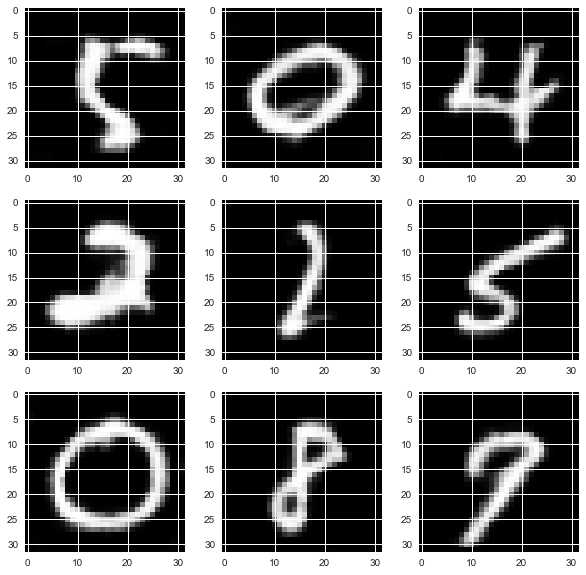

In [63]:
%matplotlib inline

import matplotlib.pyplot as plt

latents = generate_latent(latent_dimension, 9)
generator_output = model.generate(latents).detach().reshape(3, 3, 32, 32)

fig, ax = plt.subplots(3, 3, figsize=(10, 10))

for i in range(3):
    for j in range(3):
        generated_image = model.denormalise_pixels(generator_output[i][j])
        ax[i][j].imshow(generated_image, cmap='gray')

plt.show()


## Import WGAN and load in a trained Pokémon model

In [20]:
from wgan import WGAN

In [11]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

input_channels = 3
hidden_channels = 32
output_channels = 3
latent_dimension = 100

lr = 0.00005

num_epochs = 50000
batch_size = 64
image_size = 64

dataroot = '../data/gen1_pokemon/all'

dataset = dset.ImageFolder(root=dataroot,
                           transform=transforms.Compose([
                               transforms.Resize(image_size),
                               transforms.CenterCrop(image_size),
                               transforms.ToTensor()]))

data_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                         shuffle=True)

model = WGAN(image_size, input_channels, hidden_channels, output_channels, latent_dimension, lr, device=device)

## Generate Images of Pokémon

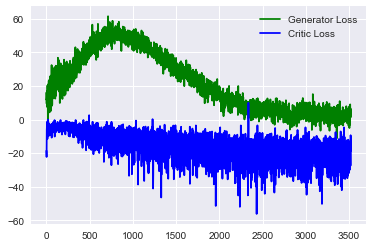

In [57]:
with open('../data/models/pokemon_32_wgan_gen_losses.pkl', 'rb') as f:
    gen_losses = pkl.load(f)

with open('../data/models/pokemon_32_wgan_critic_losses.pkl', 'rb') as f:
    critic_losses = pkl.load(f)
    
plt.plot(gen_losses, color='g', label='Generator Loss')
plt.plot(critic_losses, color='b', label='Critic Loss')
plt.legend()

plt.show()

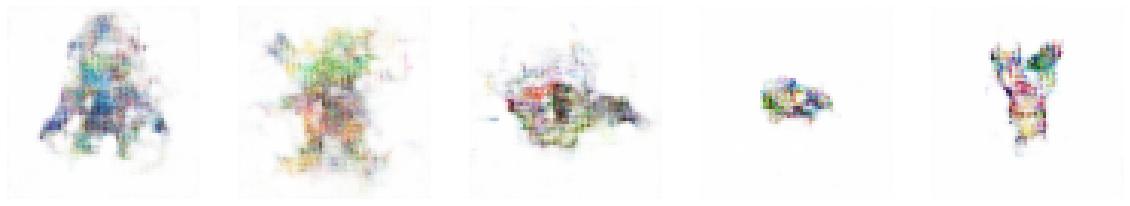

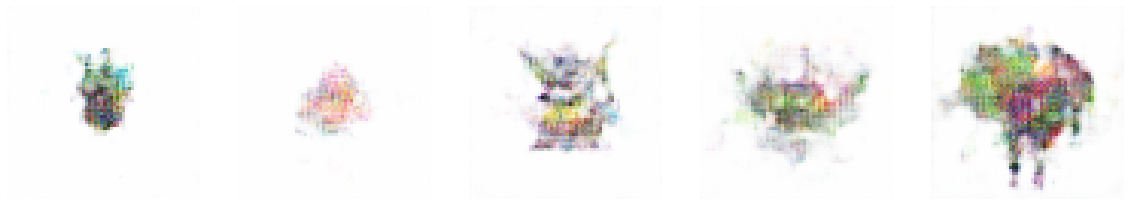

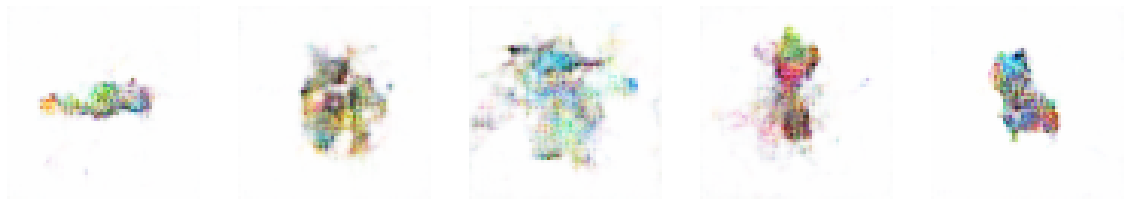

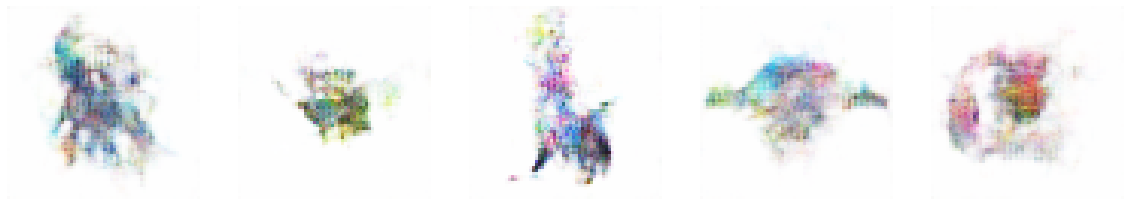

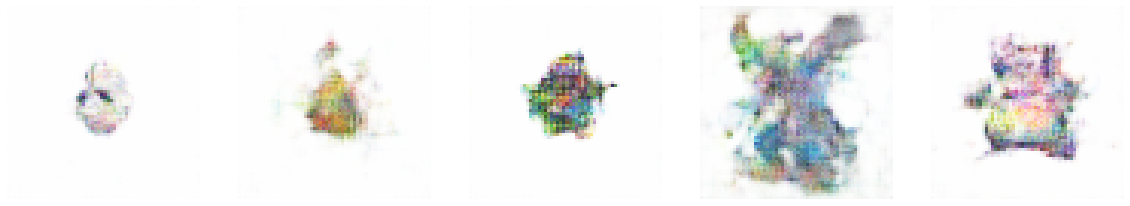

In [15]:
# Load Model 
model.load_model(load_name='../data/models/pokemon_32_wgan')

for i in range(5):
    test_latents = generate_latent(latent_dimension, 5).to(device)
    images = model.generate(test_latents)
    model.display_images(images)